# Load libraries

In [1]:
import sys
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
from scipy.sparse import csr_matrix
import logging
import os
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import scipy.stats as stats
import statsmodels.formula.api as smf
import statsmodels.api as sm
import math
import gc
import random
from sklearn.utils import shuffle
import combat
import patsy
logging.basicConfig(level=logging.INFO)
savepath = 'Lupus_study_adjusted.h5ad'

# Read data

In [5]:
%matplotlib inline
##################
# Configure file #
##################
sc.settings.verbosity = 2
sc.settings.autoshow = False
sc.settings.set_figure_params(dpi=100, dpi_save=300, format='png', frameon=False, transparent=True, fontsize=16)
plt.rcParams["image.aspect"] = "equal"
adata = sc.read(savepath, cache=True)
print(adata)
figdir = "./figures."
sc.settings.figdir = "./figures."
MASTERCOLORS = sc.pl.palettes.default_64
MASTERCOLORS.remove("#FEFFE6")
MASTERCOLORS.remove("#FFFF00")

AnnData object with n_obs × n_vars = 931108 × 1284 
    obs: 'Broad', 'CD127|IL7R|j95-27|pAbO', 'CD14|CD14|j95-20|pAbO', 'CD161|KLRB1|j95-11|pAbO', 'CD183|CXCR3|j95-12|pAbO', 'CD185|CXCR5|j95-22|pAbO', 'CD194|CCR4|j95-21|pAbO', 'CD196|CCR6|j95-17|pAbO', 'CD197|CCR7|j95-09|pAbO', 'CD19|CD19|j95-10|pAbO', 'CD25|IL2RA|j95-24|pAbO', 'CD27|CD27|j95-08|pAbO', 'CD28|CD28|j95-07|pAbO', 'CD38|CD38|j95-01|pAbO', 'CD3|CD3E|j95-16|pAbO', 'CD45RA|PTPRC|j95-28|pAbO', 'CD45RO|PTPRC|j95-19|pAbO', 'CD4|CD4|j95-14|pAbO', 'CD8|CD8A|j95-25|pAbO', 'CD95|FAS|j95-02|pAbO', 'Female', 'HLA-DR|CD74|j95-18|pAbO', 'SOURCE', 'batch', 'batch_cov', 'ct_cov', 'disease_cov', 'ind_cov', 'pop_cov', 'well', 'percent_mito', 'n_counts', 'n_genes', 'PF4', 'SDPR', 'GNG11', 'PPBP', 'DDX3Y', 'PC2', 'PC3', 'PC11', 'PC12', 'PC26', 'PC18', 'leiden', 'site', 'disease_pop_site_cov', 'ind_cov_disease_cov'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'barcodes', 'diffmap_evals', 'genes', 

# Projection

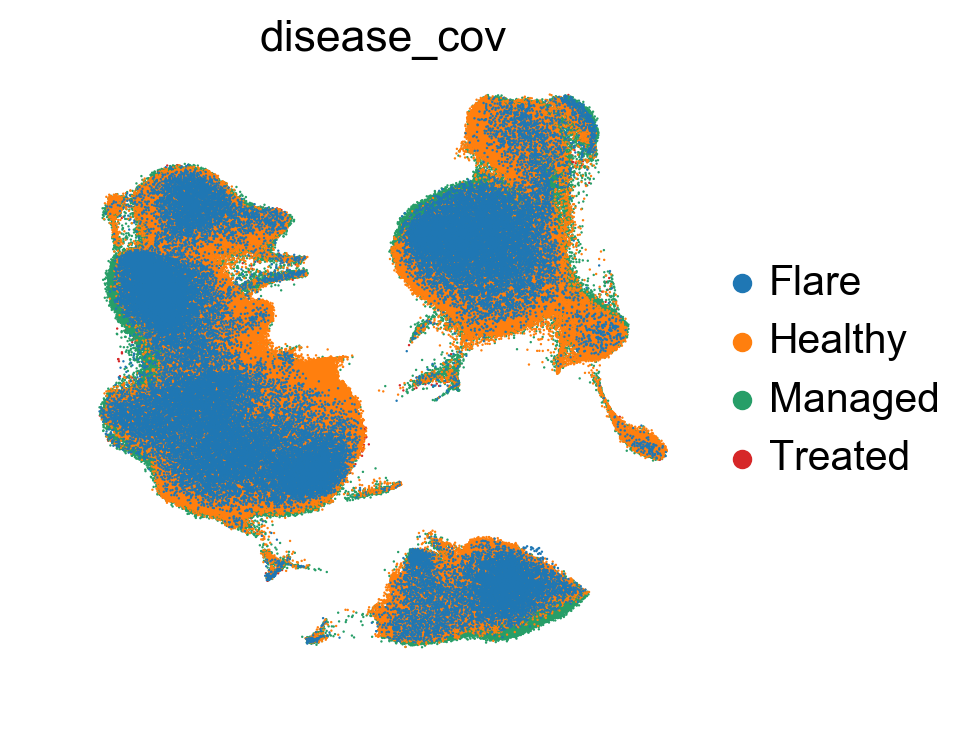

In [4]:
disease_umap = sc.pl.umap(adata, color='disease_cov', size=3, show=True, edgecolor="none", palette=sc.pl.palettes.vega_20_scanpy, save='.disease.png')

In [ ]:
sc.tl.embedding_density(adata, basis='umap', groupby='disease_cov')
sc.pl.embedding_density(adata, basis='umap', key='umap_density_disease_cov', show=True,  save='umap_density_disease_cov.png')

In [5]:
disease_umap = sc.pl.umap(adata, color='batch_cov', size=3,show=True, edgecolor="none", palette=sc.pl.palettes.vega_20_scanpy, save='.batch.png')

## Plot individual variability

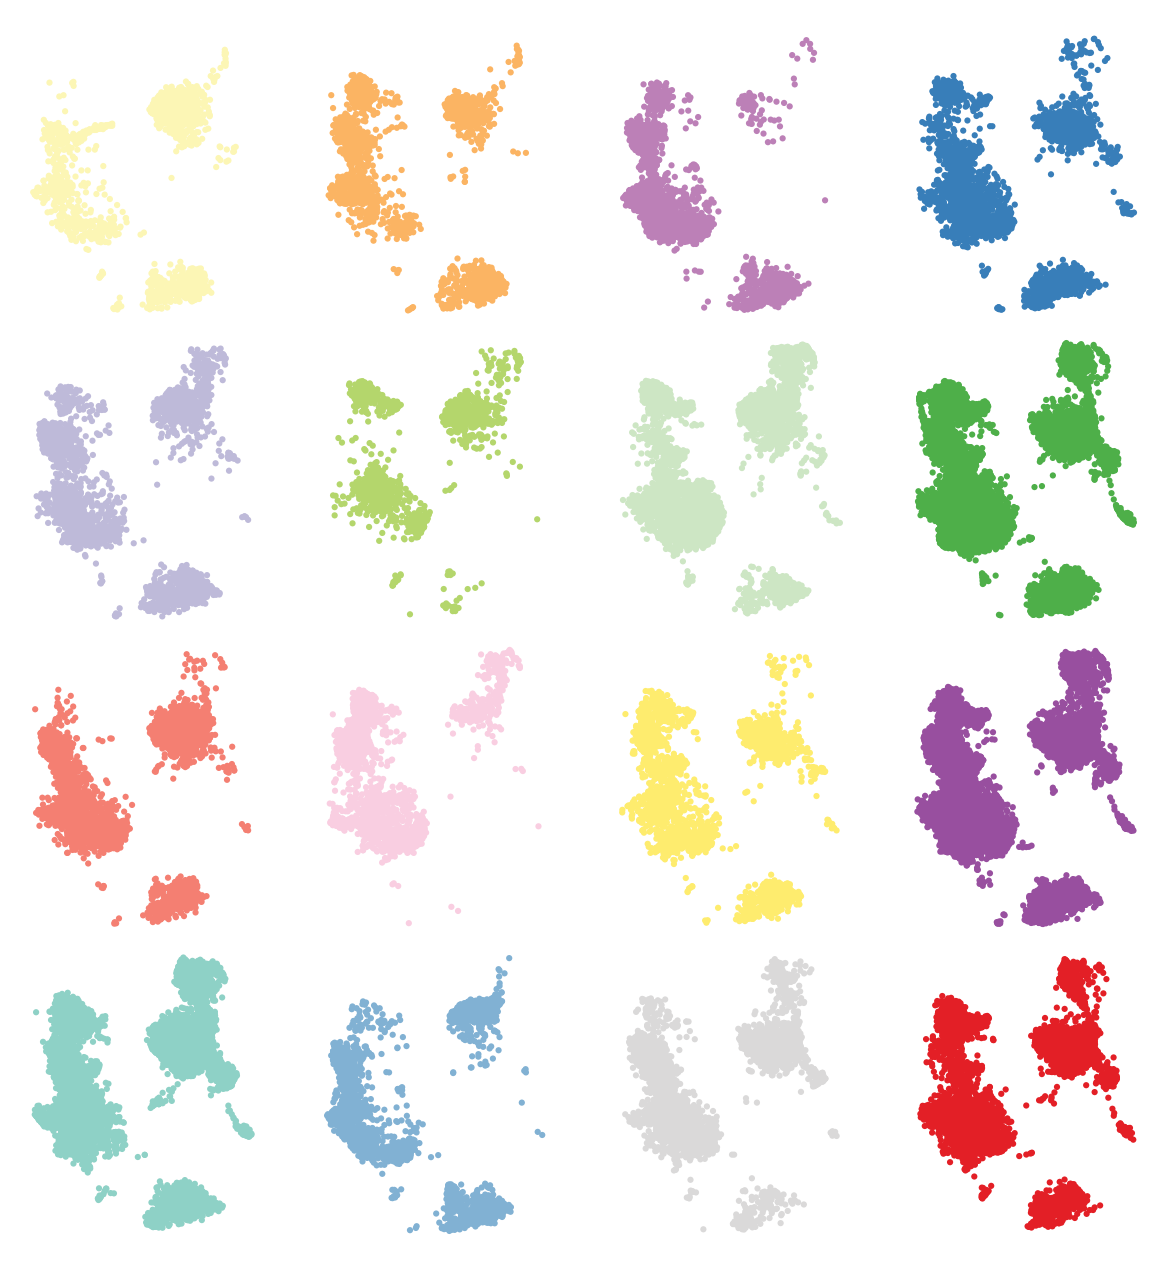

In [6]:
# Plot 16 plots for the individuals.
colors = ["#8ED1C6","#FCF6B5", "#BEBAD9", "#F47F72", "#81B1D3", "#FBB463", "#B4D66C", "#F9CEE1", "#DAD9D9", "#BC80B7", "#CDE6C4", "#FEEC6E", "#E31F26", "#387EB9", "#4EAF49", "#984F9F", "#8ED1C6","#FCF6B5", "#BEBAD9"];
fig,ax = plt.subplots(nrows=4,ncols=4, figsize=(7,7),sharex=True, sharey=True)
fig.tight_layout()
plt.subplots_adjust(wspace=-0.1, hspace=0)

batch_name = adata.obs.batch_cov.unique()[0]
batch = adata.obs.ind_cov_disease_cov[adata.obs.batch_cov==batch_name].unique();
batch = np.sort(batch.categories.values)
for ind_i in list(range(16)):
    ind = batch[ind_i]
    col = colors[ind_i]
    sc.pl.umap(adata[adata.obs.ind_cov_disease_cov==ind,], color = "ind_cov_disease_cov", title=None, palette=[col,col], ax=ax[(ind_i-1)%4,math.floor(ind_i/4)], size=20, edgecolor="none")
    ax[(ind_i-1)%4,math.floor(ind_i/4)].get_xaxis().set_visible(False)
    ax[(ind_i-1)%4,math.floor(ind_i/4)].get_yaxis().set_visible(False)
    ax[(ind_i-1)%4,math.floor(ind_i/4)].get_legend().remove()
    ax[(ind_i-1)%4,math.floor(ind_i/4)].set_title("")
    ax[(ind_i-1)%4,math.floor(ind_i/4)].set_aspect("equal")

fig.savefig(figdir+'/'+batch_name+'.ind.png')

# Rank genes and plot leiden groups

In [ ]:
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

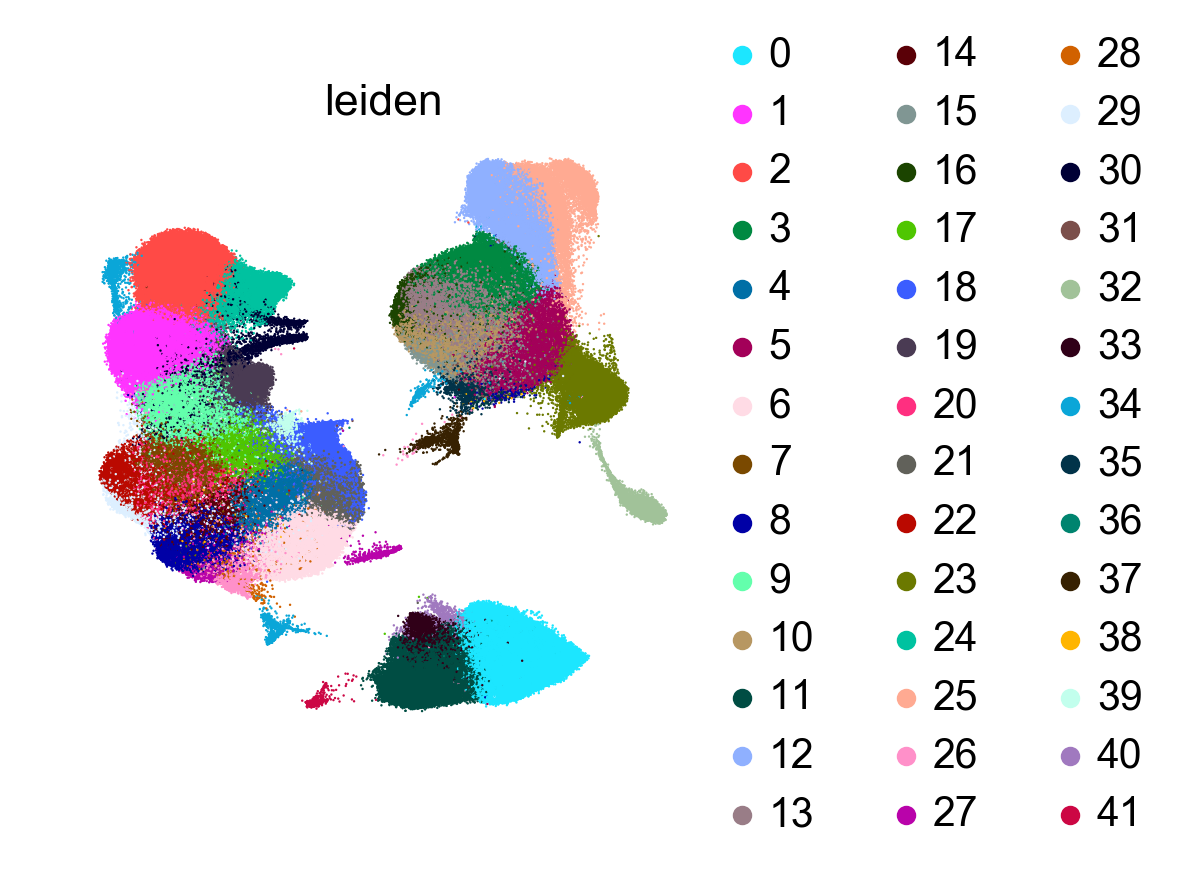

In [4]:
sc.pl.umap(adata, color='leiden', size=3, show=True, edgecolor="none", save='.leiden.png', palette=MASTERCOLORS)

# Most expressed genes per leiden group

In [5]:
pd.set_option('display.max_columns', None)
unique_leiden = np.unique(adata.obs['leiden'].values)
# Compile list of top genes
GeneRanks = pd.DataFrame()
for ii in range(len(unique_leiden)):
    GeneRanks[str('leiden_' + str(ii))] = adata.var_names[np.flipud(np.argsort(np.mean(adata.X[adata.obs['leiden'] == str(ii)], axis=0)))]
GeneRanks.to_csv('Flare_study_top_expression.csv')
GeneRanks.head(20)

leiden_0  leiden_1 leiden_2       leiden_3   leiden_4  leiden_5  \
0       TCL1A      GZMH    KLRF1           MNDA       FHIT      CST3   
1       CD79A      CCL5     PRF1         IFITM3       CCR7    LGALS2   
2       MS4A1      NKG7    SPON2           FCN1        LTB    TYROBP   
3       CD79B    FGFBP2     GZMB         LGALS2  PRKCQ-AS1      CTSS   
4      VPREB3      CST7     GNLY           TYMP        CD7      AIF1   
5       FCER2      CD3D   FGFBP2           CD14        AK5    MS4A6A   
6   LINC00926      IL32    CLIC3         MS4A6A     TMIGD2      FCN1   
7         LTB      GZMA    KLRB1           CST3        TXK      GPX1   
8    PPAPDC1B      GNLY      CD7           CTSS      CD247      CSTA   
9        CD22      CD3G     NKG7           CSTA       GZMB      LST1   
10      BANK1      CD8A     CTSW         TYROBP      KLRF1   HLA-DRA   
11      IGLL5     KLRD1     CST7       TNFSF13B      CD79A     NEAT1   
12    RALGPS2     KLRG1     GZMA           IFI6      MS4A1      PSAP   
13    HLA-DRA      GZMB    CD247           VCAN      TSHZ2      MNDA   
14      MEF2C      CTSW     HOPX           FGL2      ADTRP      FGL2   
15      CXCR4  C12orf75    KLRD1           AIF1       PRF1      CPVL   
16   HLA-DQB1       CD2   IGFBP7  RP11-1143G9.4      SPON2      VCAN   
17      FCRL1    ZNF683   AKR1C3        S100A12       GNLY  HLA-DRB1   
18   HLA-DQA1      CD8B    MYOM2        S100A11      TCL1A    LGALS1   
19      BCL7A      CCL4    IL2RB           PSAP     CDCA7L      TYMP   

         leiden_6       leiden_7  leiden_8 leiden_9      leiden_10  \
0   RP11-291B21.2        TNFRSF4       LTB     GZMK        S100A12   
1            CD8B           IL32      CCR7     CCL5           VCAN   
2           S100B          ITGB1  HLA-DQA1    DUSP2           CSTA   
3            CD8A            LTB    FCER1A     LYAR           MNDA   
4            CCR7          GATA3      PLD4     IL32           CD14   
5          RPS4Y1          KLRB1     STMN1     GZMA           FCN1   
6             CD7           CD69    TMIGD2     CMC1         TYROBP   
7            PASK  RP11-403A21.2       IGJ     CST7           GPX1   
8       PRKCQ-AS1         CD40LG      CD1C     CD8B           CTSS   
9             TXK           RORA      SPIB     NKG7         MS4A6A   
10          CRTAM         ARID5B     ITM2C     CD3D           CST3   
11           CTSW          CRIP2       ID3     CD8A         LGALS1   
12         EIF1AY   RP11-138A9.2    LILRA4   PIK3R1  RP11-1143G9.4   
13           GZMM         PIK3R1  DNASE1L3     GZMM           CD36   
14          DDX3Y            CD2     CD79B     CCL4          MGST1   
15           CPA5           CCR6   CLEC10A      CD2           RBP7   
16         TMIGD2            JUN      MZB1     CD3G            TKT   
17          CXCR4   RP11-138A9.1       CD7     RGS1          CSF3R   
18         SPINK2           LMNA       SCT    SYNE2           LST1   
19   RP1-313I6.12          SYNE2   RALGPS2     LAG3        S100A11   

       leiden_11      leiden_12      leiden_13   leiden_14  leiden_15  \
0   RP5-887A10.1         CDKN1C        S100A12       ADTRP  SNORD3B-2   
1          MS4A1         FCGR3A          THBS1       TSHZ2    SNORD3D   
2          CD79A           HES4           VCAN      FAM13A    SNORD3A   
3          BANK1          MS4A7          SAP30        FHIT  SNORD3B-1   
4      TNFRSF13B  RP11-290F20.3         RNASE2   PRKCQ-AS1    S100A12   
5     AL928768.3         TCF7L2          CD163     SLC40A1       VCAN   
6     AC079767.4           LST1           FCN1       AP3M2       CSTA   
7        RALGPS2            CKB          IL1R2        CCR7       MNDA   
8            LTB         IFITM3           MNDA         LTB     TYROBP   
9            BLK         LRRC25           CSTA         AK5       GPX1   
10         CD79B           AIF1           IFI6         TXK       FCN1   
11        COBLL1           RHOC           CST3      TMIGD2       CTSS   
12           IGJ       SERPINA1           RETN       FCRL5        FOS   

# Example antibodies

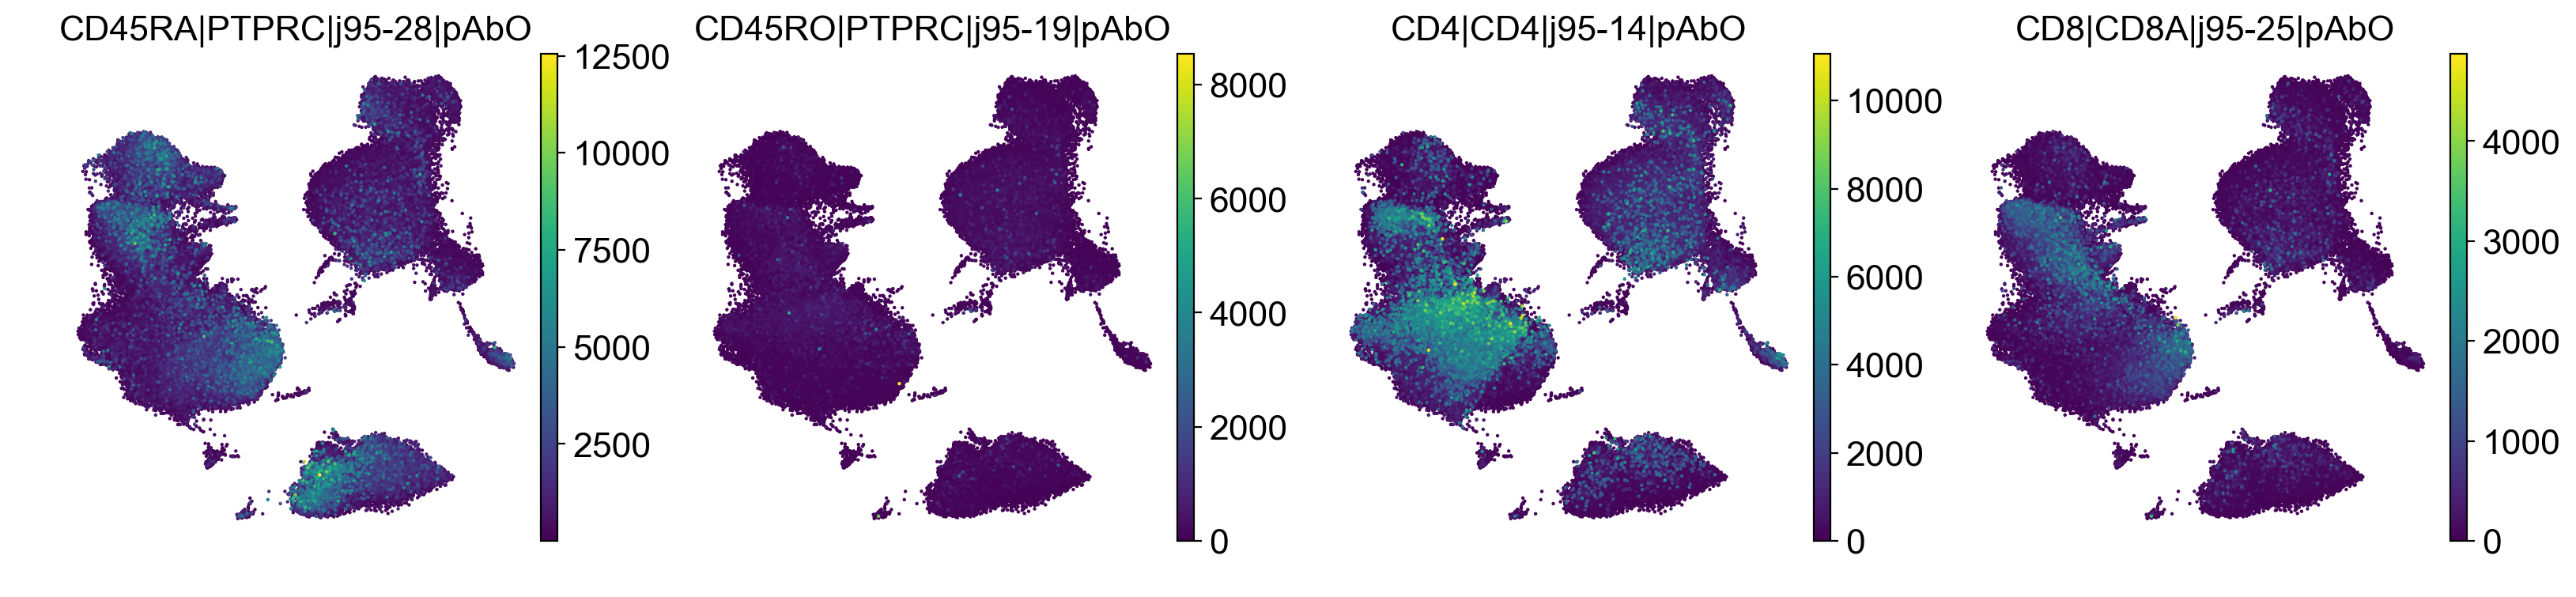

In [6]:
sc.pl.umap(adata, color=['CD45RA|PTPRC|j95-28|pAbO', 'CD45RO|PTPRC|j95-19|pAbO', 'CD4|CD4|j95-14|pAbO', 'CD8|CD8A|j95-25|pAbO'], size=10)

# Label cell populations

In [6]:
adata.obs['ct_cov'] = adata.obs['ct_cov'].astype('object')
adata.obs['ct_cov'].loc[adata.obs.leiden == "0"] = "B Cells" ## good                                                                                    
adata.obs['ct_cov'].loc[adata.obs.leiden == "1"] = "CD8+ T Cells" ## good                                                                                    
adata.obs['ct_cov'].loc[adata.obs.leiden == "2"] = "Natural Killer Cells" ## good                                                                                     
adata.obs['ct_cov'].loc[adata.obs.leiden == "3"] = "Classical Monocytes" ## good                                                                                    
adata.obs['ct_cov'].loc[adata.obs.leiden == "4"] = "CD4+ T Cells" ## good                                                                                    
adata.obs['ct_cov'].loc[adata.obs.leiden == "5"] = "Classical Monocytes" ## good                                                                                    
adata.obs['ct_cov'].loc[adata.obs.leiden == "6"] = "CD8+ T Cells" ## good                                                                                    
adata.obs['ct_cov'].loc[adata.obs.leiden == "7"] = "CD8+ T Cells" ## good                                                                                    
adata.obs['ct_cov'].loc[adata.obs.leiden == "8"] = "CD4+ T Cells" ## good                                                                                    
adata.obs['ct_cov'].loc[adata.obs.leiden == "9"] = "CD8+ T Cells" ## good                                                                                    
adata.obs['ct_cov'].loc[adata.obs.leiden == "10"] = "Classical Monocytes" ## good                                                                                  
adata.obs['ct_cov'].loc[adata.obs.leiden == "11"] = "B Cells" ## good                                                                                    
adata.obs['ct_cov'].loc[adata.obs.leiden == "12"] = "Nonclassical Monocytes" ## good                                                                                   
adata.obs['ct_cov'].loc[adata.obs.leiden == "13"] = "Classical Monocytes" ## good  Macro                                                                                 
adata.obs['ct_cov'].loc[adata.obs.leiden == "14"] = "CD4+ T Cells" ## good                                                                                  
adata.obs['ct_cov'].loc[adata.obs.leiden == "15"] = "Classical Monocytes" ## good                                                                                   
adata.obs['ct_cov'].loc[adata.obs.leiden == "16"] = "Classical Monocytes" ## good                                                                                   
adata.obs['ct_cov'].loc[adata.obs.leiden == "17"] = "CD4+ T Cells" ## good                                                                                  
adata.obs['ct_cov'].loc[adata.obs.leiden == "18"] = "CD8+ T Cells" ## good                                                                              
adata.obs['ct_cov'].loc[adata.obs.leiden == "19"] = "CD8+ T Cells" ## good                                                                               
adata.obs['ct_cov'].loc[adata.obs.leiden == "20"] = "CD4+ T Cells" ## good                                                                                   
adata.obs['ct_cov'].loc[adata.obs.leiden == "21"] = "CD8+ T Cells" ##
adata.obs['ct_cov'].loc[adata.obs.leiden == "22"] = "CD4+ T Cells" ##
adata.obs['ct_cov'].loc[adata.obs.leiden == "23"] = "Classical Dendritic Cells" ##
adata.obs['ct_cov'].loc[adata.obs.leiden == "24"] = "Natural Killer Cells" ##
adata.obs['ct_cov'].loc[adata.obs.leiden == "25"] = "Nonclassical Monocytes" ##
adata.obs['ct_cov'].loc[adata.obs.leiden == "26"] = "Megakaryocytes" ##
adata.obs['ct_cov'].loc[adata.obs.leiden == "27"] = "Progenitor Cells" ##
adata.obs['ct_cov'].loc[adata.obs.leiden == "28"] = "RBCs" ##
adata.obs['ct_cov'].loc[adata.obs.leiden == "29"] = "CD4+ T Cells" ##
adata.obs['ct_cov'].loc[adata.obs.leiden == "30"] = "Progenitor Cells" ##
adata.obs['ct_cov'].loc[adata.obs.leiden == "31"] = "Classical Monocytes" ##
adata.obs['ct_cov'].loc[adata.obs.leiden == "32"] = "Plasmacytoid Dendritic Cells" ##
adata.obs['ct_cov'].loc[adata.obs.leiden == "33"] = "B Cells" ##
adata.obs['ct_cov'].loc[adata.obs.leiden == "34"] = "RBCs" ##
adata.obs['ct_cov'].loc[adata.obs.leiden == "35"] = "Classical Monocytes" ##
adata.obs['ct_cov'].loc[adata.obs.leiden == "36"] = "B Cells" ##
adata.obs['ct_cov'].loc[adata.obs.leiden == "37"] = "Megakaryocytes" ##
adata.obs['ct_cov'].loc[adata.obs.leiden == "38"] = "CD4+ T Cells" ##
adata.obs['ct_cov'].loc[adata.obs.leiden == "39"] = "CD4+ T Cells" ##
adata.obs['ct_cov'].loc[adata.obs.leiden == "40"] = "Doublets" ##
adata.obs['ct_cov'].loc[adata.obs.leiden == "41"] = "B Cells" ##
adata.obs['ct_cov'] = adata.obs.ct_cov.astype('category')
sc.settings.set_figure_params(dpi=100, dpi_save=300, format='png', frameon=False, transparent=True, fontsize=16)
plt.rcParams["image.aspect"] = "equal"
MasterORDER = ['Classical Monocytes','Nonclassical Monocytes', 'Classical Dendritic Cells', 'Plasmacytoid Dendritic Cells', 'CD4+ T Cells', 'CD8+ T Cells', 'Natural Killer Cells', 'B Cells', 'Progenitor Cells', 'Megakaryocytes', 'RBCs', 'Doublets']
#colorrs = ["#E58606","#5D69B1","#52BCA3","#99C945","#CC61B0","#24796C","#DAA51B","#2F8AC4","#764E9F","#ED645A","#CC3A8E",'#BC23FF', '#D790FF']
colorrs = ["#4E79A7","#A0CBE8","#F28E2B","#FFBE7D","#8CD17D","#B6992D","#499894","#E15759","#FF9D9A","#79706E","#D37295","#FABFD2","#B07AA1","#D4A6C8","#9D7660",
                 "#E58606", "#5D69B1", "#24796C", '#DAA51B', '#000000', '#99C945', '#ED645A']

adata.obs['ct_cov'] = adata.obs['ct_cov'].cat.reorder_categories(MasterORDER)
adata.uns['ct_cov_colors'] = colorrs
celltype_umap = sc.pl.umap(adata, color='ct_cov', show=True, size=3, edgecolor="none")

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


# Proportions and Statistics

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


as a proportion of total PBMC: Healthy vs. Managed WEIGHTED BY TOTAL PBMC COUNTS


/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Beta                          Cell          Pval
0     -11.50419831646009           Classical Monocytes  1.954774e-14
1     -2.379088401697455        Nonclassical Monocytes  4.181614e-07
2    0.14525535515645266     Classical Dendritic Cells  1.620512e-01
3     0.4792318012872171  Plasmacytoid Dendritic Cells  1.473005e-22
4     11.975687575304825                  CD4+ T Cells  1.190228e-17
5     0.6292000700302272                  CD8+ T Cells  6.486823e-01
6     0.6237044050017938          Natural Killer Cells  3.001208e-01
7   -0.11844523252694505                       B Cells  9.174054e-01
8   -0.29997819797862685              Progenitor Cells  8.452002e-05
9     0.4113289143292957                Megakaryocytes  5.807068e-06
10  -0.02076637784059892                          RBCs  7.524333e-01
11    0.0344047532312994                      Doublets  1.886720e-02

as a proportion of total PBMC: Healthy vs. Treated WEIGHTED BY TOTAL PBMC COUNTS


Beta                          Cell      Pval
0   -10.645012961624234           Classical Monocytes  0.003555
1   -2.1993741832012583        Nonclassical Monocytes  0.010731
2    0.9755815006388003     Classical Dendritic Cells  0.000374
3     0.658091948149437  Plasmacytoid Dendritic Cells  0.000522
4     16.50071079403429                  CD4+ T Cells  0.000718
5    -8.579556619306711                  CD8+ T Cells  0.078148
6   -5.4185206490010245          Natural Killer Cells  0.010359
7     7.161311894385423                       B Cells  0.003608
8   -0.5283753237987108              Progenitor Cells  0.000562
9     1.017592365013413                Megakaryocytes  0.002363
10   0.3717496352358931                          RBCs  0.100442
11  0.07801432907921424                      Doublets  0.310624

as a proportion of total PBMC: Healthy vs. Flare WEIGHTED BY TOTAL PBMC COUNTS


Beta                          Cell          Pval
0      -6.1262969391712385           Classical Monocytes  1.968993e-02
1   -0.0033729465128542746        Nonclassical Monocytes  9.951771e-01
2       0.9647099990550174     Classical Dendritic Cells  7.052613e-07
3       0.5967054664093894  Plasmacytoid Dendritic Cells  3.444446e-06
4         9.80795486982258                  CD4+ T Cells  1.449098e-03
5       -5.096847611870451                  CD8+ T Cells  8.872319e-02
6       0.5449592970824583          Natural Killer Cells  6.616641e-01
7      -0.8707380074830589                       B Cells  6.488776e-01
8      -0.9420274613981265              Progenitor Cells  4.096657e-07
9       0.8081175318529408                Megakaryocytes  1.369086e-04
10     0.19030226587323532                          RBCs  1.763579e-01
11     0.02944078976809037                      Doublets  4.131809e-01

as a proportion of total PBMC: Treated vs. Flare WEIGHTED BY TOTAL PBMC COUNTS


Beta                          Cell      Pval
0       4.518716022452996           Classical Monocytes  0.560793
1      2.1960012366884047        Nonclassical Monocytes  0.073465
2   -0.010871501583783721     Classical Dendritic Cells  0.966379
3    -0.06138648174004814  Plasmacytoid Dendritic Cells  0.441761
4      -6.692755924211715                  CD4+ T Cells  0.012794
5       3.482709007436256                  CD8+ T Cells  0.509208
6       5.963479946083487          Natural Killer Cells  0.050953
7      -8.032049901868485                       B Cells  0.092689
8    -0.41365213759941494              Progenitor Cells  0.453816
9     -0.2094748331604727                Megakaryocytes  0.110438
10   -0.18144736936265787                          RBCs  0.034781
11   -0.04857353931112387                      Doublets  0.243279

as a proportion of total PBMC: Treated vs. Managed WEIGHTED BY TOTAL PBMC COUNTS


Beta                          Cell      Pval
0     -0.8591853548358488           Classical Monocytes  0.868587
1     -0.1797142184961953        Nonclassical Monocytes  0.913880
2     -0.8303261454823478     Classical Dendritic Cells  0.023705
3     -0.1788601468622198  Plasmacytoid Dendritic Cells  0.088072
4      -4.525023218729466                  CD4+ T Cells  0.203725
5       9.208756689336939                  CD8+ T Cells  0.041149
6        6.04222505400283          Natural Killer Cells  0.004443
7      -7.279757126912364                       B Cells  0.093685
8     0.22839712582008448              Progenitor Cells  0.428523
9     -0.6062634506841176                Megakaryocytes  0.017062
10    -0.3925160130764922                          RBCs  0.047924
11  -0.043609575847914965                      Doublets  0.390771

as a proportion of total PBMC: Healthy vs. SLE WEIGHTED BY TOTAL PBMC COUNTS


Beta                          Cell          Pval
0     -11.472508624165584           Classical Monocytes  4.395427e-14
1      -2.372459927116229        Nonclassical Monocytes  2.708841e-07
2     0.17483963065022645     Classical Dendritic Cells  9.075429e-02
3     0.48587986841979824  Plasmacytoid Dendritic Cells  6.268265e-24
4      12.142585896627367                  CD4+ T Cells  7.630676e-19
5      0.2895496508773272                  CD8+ T Cells  8.360465e-01
6      0.4008464947059811          Natural Killer Cells  5.253090e-01
7     0.12357026987373998                       B Cells  9.127264e-01
8     -0.3084022645638515              Progenitor Cells  6.379229e-05
9     0.43368998239621287                Megakaryocytes  1.306155e-06
10  -0.006289045789896884                          RBCs  9.224368e-01
11    0.03545622455304079                      Doublets  1.428925e-02

as a proportion of total PBMC: Healthy vs. Treated&Flare WEIGHTED BY TOTAL PBMC COUNTS


Beta                          Cell      Pval
0   -10.645012961624234           Classical Monocytes  0.003555
1   -2.1993741832012583        Nonclassical Monocytes  0.010731
2    0.9755815006388003     Classical Dendritic Cells  0.000374
3     0.658091948149437  Plasmacytoid Dendritic Cells  0.000522
4     16.50071079403429                  CD4+ T Cells  0.000718
5    -8.579556619306711                  CD8+ T Cells  0.078148
6   -5.4185206490010245          Natural Killer Cells  0.010359
7     7.161311894385423                       B Cells  0.003608
8   -0.5283753237987108              Progenitor Cells  0.000562
9     1.017592365013413                Megakaryocytes  0.002363
10   0.3717496352358931                          RBCs  0.100442
11  0.07801432907921424                      Doublets  0.310624

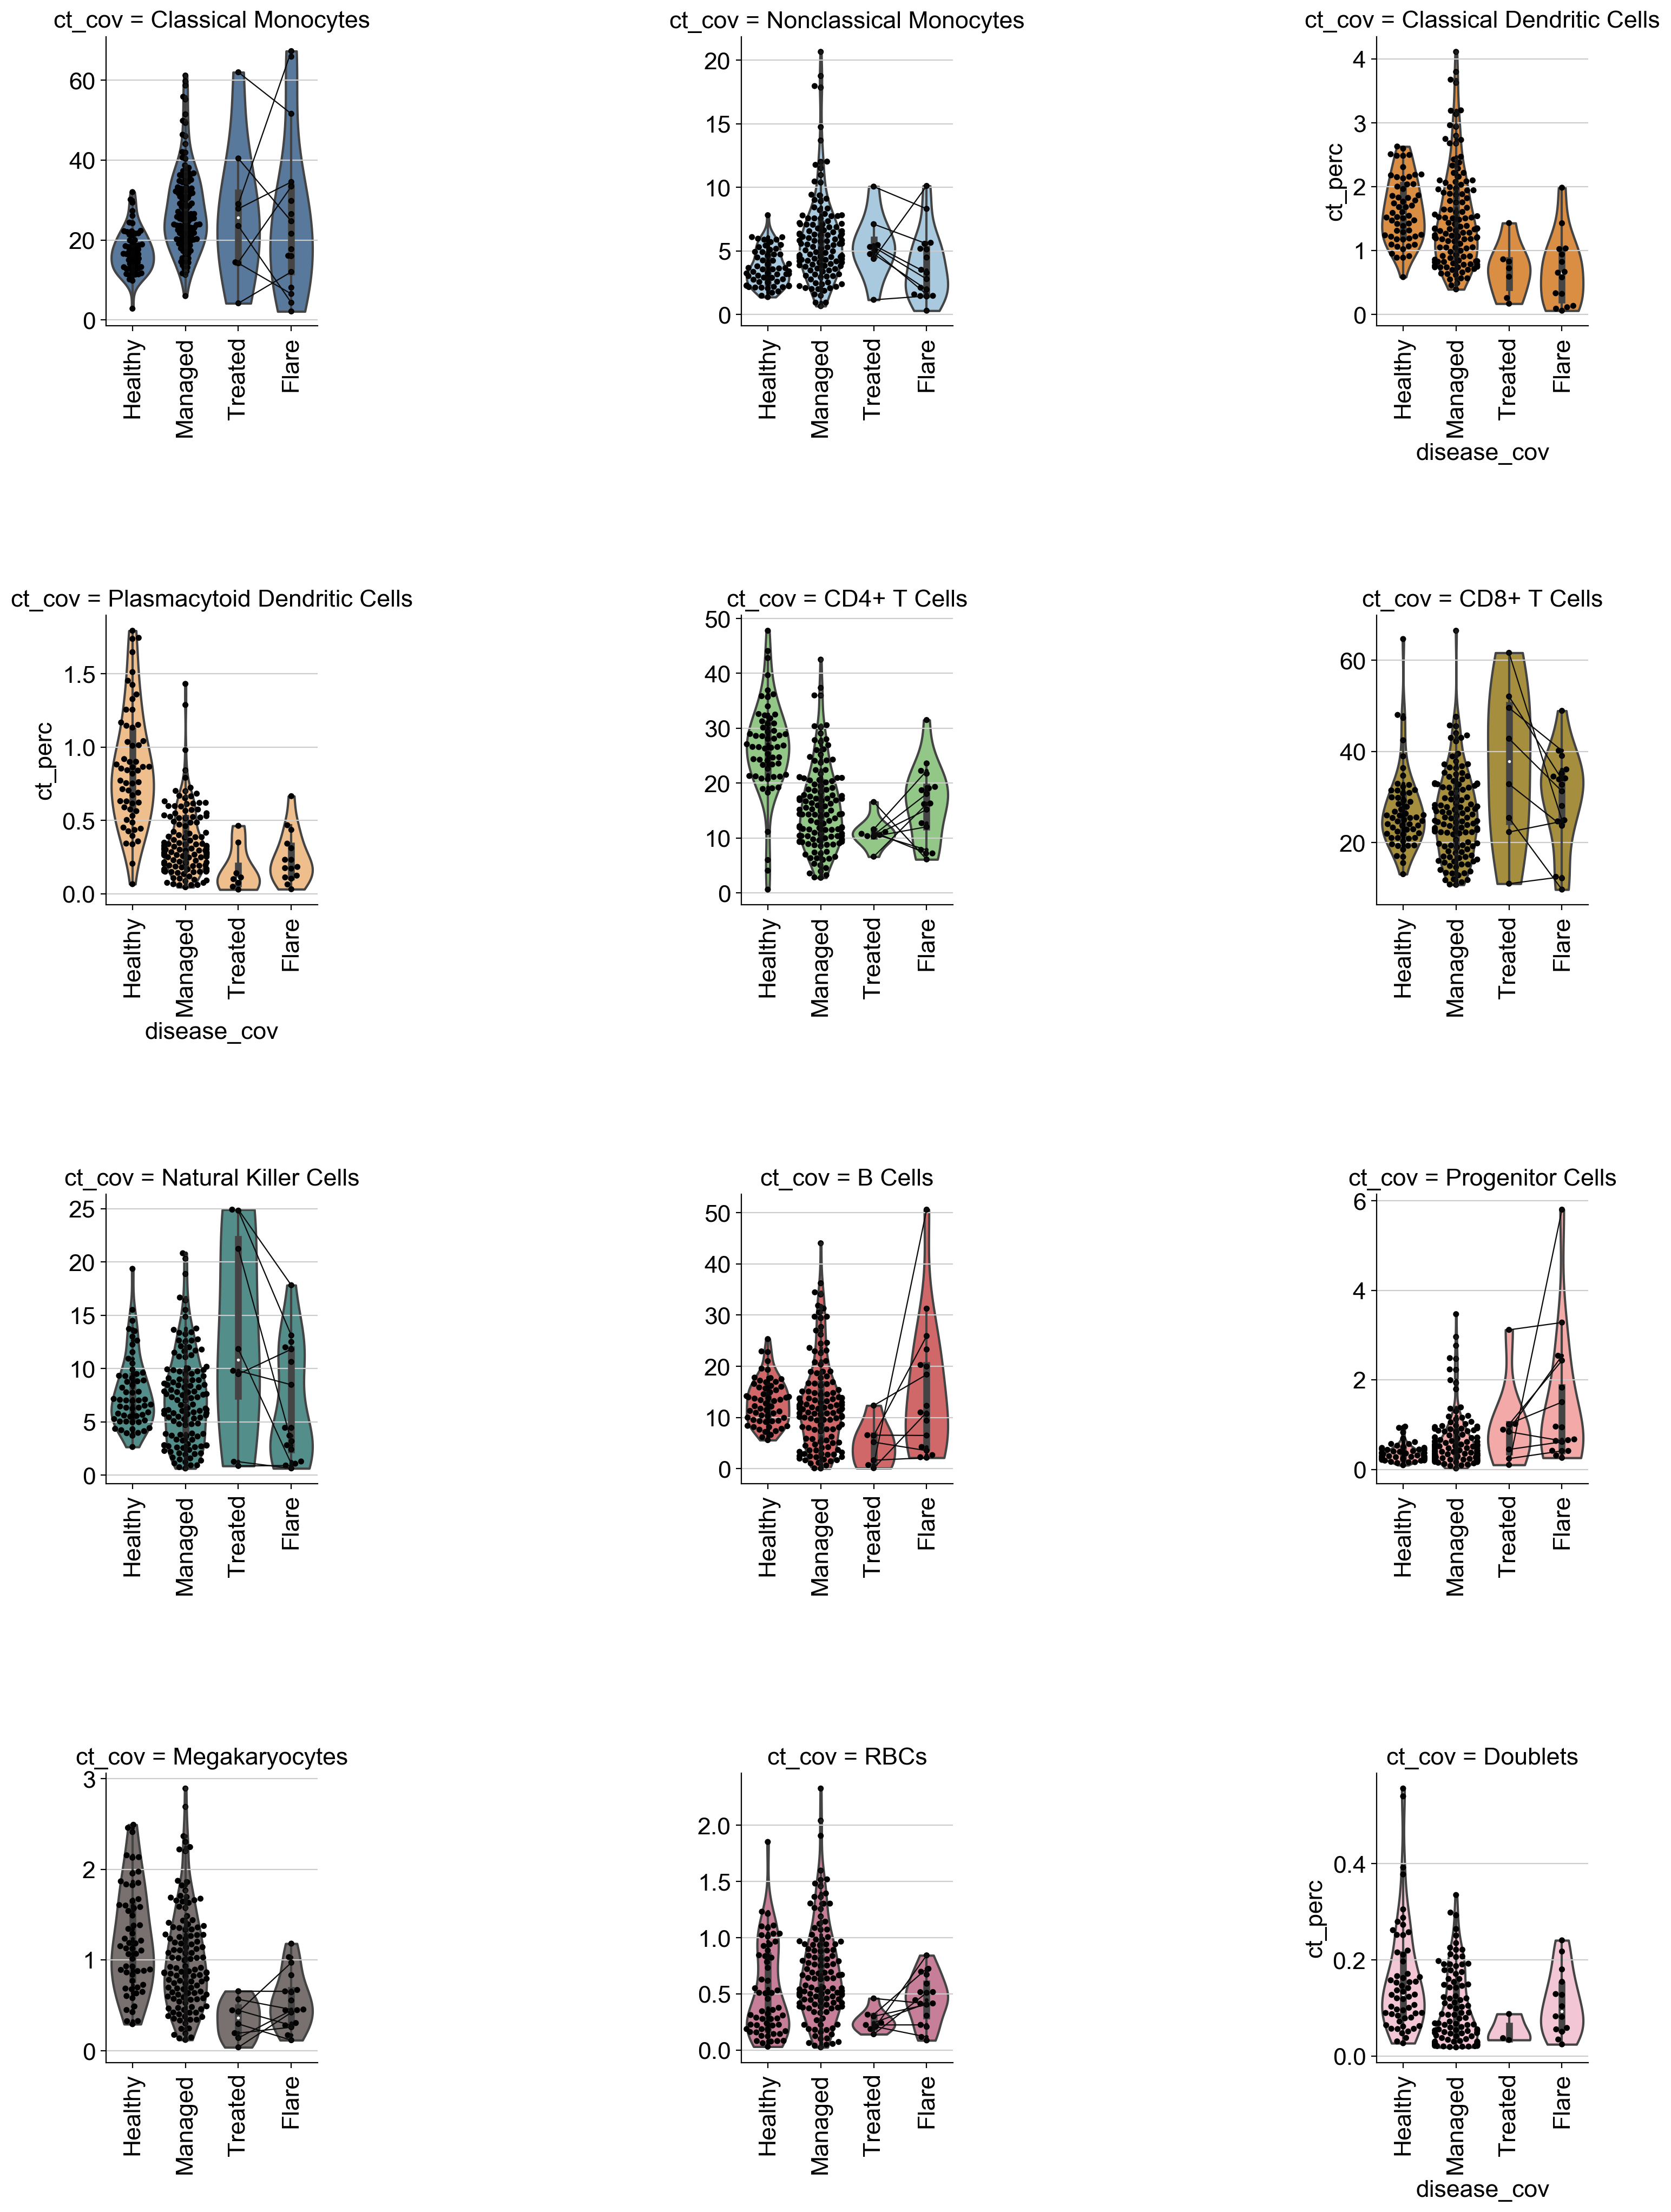

In [9]:
## Make proportion plots
adata_obs_small = adata.obs
ind_count = adata_obs_small.groupby(['ind_cov_disease_cov','ct_cov','disease_cov','pop_cov', 'ind_cov'])['ct_cov'].count()
ind_count_sums = ind_count.groupby(level=[0]).sum()
ind_count_sums = ind_count_sums.reset_index(name="counts")
ind_perc = ind_count/ind_count.groupby(level=[0]).transform(sum)*100
ind_perc = ind_perc.reset_index(name="ct_perc")
# Add weights to WLS
ind_perc['counts'] = ind_count.values.tolist()

ind_perc['ind_count_sum'] = list(np.zeros(len(ind_count.values.tolist()),dtype=int))
# Add total sums per individual to structure
for ii in range(len(ind_count_sums)):
    ind_perc['ind_count_sum'][ind_perc.ind_cov_disease_cov==ind_count_sums.ind_cov_disease_cov[ii]] = ind_count_sums.counts[ii]

# Filter samples that have < 100 cells
ind_perc = ind_perc[ind_perc.ind_cov_disease_cov.isin(ind_count_sums.ind_cov_disease_cov[ind_count_sums.counts > 100])]

cg_cov = pd.DataFrame( {    'ct_cov':['Classical Monocytes','Nonclassical Monocytes', 'Classical Dendritic Cells', 'Plasmacytoid Dendritic Cells', 'CD4+ T Cells', 'CD8+ T Cells', 'Natural Killer Cells', 'B Cells', 'Progenitor Cells', 'Megakaryocytes', 'RBCs', 'Doublets'],
                          'ct_group':['mono',               'mono',                   'mono',                      'mono',                         'lymph',        'lymph',        'lymph',                'lymph',   'Progenitor',       'MK',             'RBCs',  'Doublets']})

# Add cell type macrogroup as observation
adata.obs['ct_group'] = adata.obs['ct_cov'].tolist()
celltypes = np.unique(cg_cov['ct_cov'].tolist())
for ii in range(len(celltypes)):
    adata.obs['ct_group'][adata.obs['ct_cov']==cg_cov['ct_cov'][ii]] = cg_cov['ct_group'][ii]

ind_perc.ind_cov_disease_cov = ind_perc.ind_cov_disease_cov.apply(lambda x: x.split('_')[0])
ind_count_sums.ind_cov_disease_cov = ind_count_sums.ind_cov_disease_cov.apply(lambda x: x.split('_')[0])
ind_perc = ind_perc.set_index('ct_cov').join(cg_cov.set_index('ct_cov'))
ind_perc.ind_cov_disease_cov = ind_perc.ind_cov_disease_cov.astype("str")
ind_perc.reset_index(inplace=True)
ind_perc.ct_cov = ind_perc.ct_cov.astype('category')
ind_perc.ct_cov = ind_perc.ct_cov.cat.reorder_categories(adata.obs.ct_cov.cat.categories.values)

perc_plot = sns.catplot(x='disease_cov', y='ct_perc', order=[ "Healthy", "Managed", "Treated", "Flare"], hue='ct_cov', data=ind_perc, kind='violin', col_order=MasterORDER, col='ct_cov', col_wrap=3, cut=0, dodge=False, aspect=1, sharex=False, sharey=False, palette=colorrs)

for ct_i in list(range(len(MasterORDER))):
    ct = MasterORDER[ct_i]
    sns.swarmplot(x="disease_cov", y="ct_perc", data=ind_perc[ind_perc.ct_cov == ct], order=[ "Healthy", "Managed", "Treated", "Flare"], color="0", size=4, ax=perc_plot.axes[ct_i])
    try:
        sns.pointplot(x="disease_cov", y="ct_perc", hue="ind_cov", data=ind_perc[ind_perc.ct_cov == ct], order=[ "Healthy", "Managed", "Treated", "Flare"], color="0", scale=0.3, ax=perc_plot.axes[ct_i])
    except:
        continue
    perc_plot.axes[ct_i].get_yaxis().label.set_visible(False)
    perc_plot.axes[ct_i].get_xaxis().label.set_visible(False)
    perc_plot.axes[ct_i].get_legend().remove()
    perc_plot.set_xticklabels(rotation=90)
    perc_plot.fig.subplots_adjust(wspace=2, hspace = 1)
    
perc_plot.savefig(figdir+"/violin.ct_cov_figure6b.png")
perc_plot.savefig(figdir+"/violin.ct_cov_figure6b.pdf")

# Statistical tests...
print('as a proportion of total PBMC: Healthy vs. Managed WEIGHTED BY TOTAL PBMC COUNTS')
all_out = pd.DataFrame();
ind_perc0 = ind_perc[ind_perc.disease_cov.isin(['Healthy', 'Managed'])]
HEALTHYMANAGED_effect = {}
for ct_i in list(range(len(ind_perc0.ct_cov.cat.categories))):
    ct = ind_perc0.ct_cov.cat.categories[ct_i]
    ct_perc = ind_perc0.ct_perc[ind_perc0.ct_cov==ct]
    weights = ind_perc0.ind_count_sum[ind_perc0.ct_cov==ct]
    disease = ind_perc0.disease_cov[ind_perc0.ct_cov==ct]
    disease = disease.astype("str")
    disease.values[disease=="Managed"] = 0
    disease.values[disease=="Healthy"] = 1
    disease = sm.add_constant(disease)
    est=sm.WLS(ct_perc.astype(float), disease.astype(float), weights=weights)
    #est=sm.OLS(ct_perc.astype(float), disease.astype(float))
    est=est.fit()
    effect=est.params[1]
    pval=est.pvalues[1]
    HEALTHYMANAGED_effect[ct] = effect
    all_out = all_out.append(({"Cell":str(ct),"Beta":str(effect),"Pval":str(pval)}), ignore_index=True)
    all_out['Pval'] = all_out['Pval'].astype(float)
display(all_out)

# Statistical tests...
print('as a proportion of total PBMC: Healthy vs. Treated WEIGHTED BY TOTAL PBMC COUNTS')
all_out = pd.DataFrame();
ind_perc0 = ind_perc[ind_perc.disease_cov.isin(['Healthy', 'Treated'])]
HEALTHYTREATED_effect = {}
for ct_i in list(range(len(ind_perc0.ct_cov.cat.categories))):
    ct = ind_perc0.ct_cov.cat.categories[ct_i]
    ct_perc = ind_perc0.ct_perc[ind_perc0.ct_cov==ct]
    weights = ind_perc0.ind_count_sum[ind_perc0.ct_cov==ct]
    disease = ind_perc0.disease_cov[ind_perc0.ct_cov==ct]
    disease = disease.astype("str")
    disease.values[disease=="Treated"] = 0
    disease.values[disease=="Healthy"] = 1
    disease = sm.add_constant(disease)
    est=sm.WLS(ct_perc.astype(float), disease.astype(float), weights=weights)
    #est=sm.OLS(ct_perc.astype(float), disease.astype(float))
    est=est.fit()
    effect=est.params[1]
    pval=est.pvalues[1]
    HEALTHYTREATED_effect[ct] = effect
    all_out = all_out.append(({"Cell":str(ct),"Beta":str(effect),"Pval":str(pval)}), ignore_index=True)
    all_out['Pval'] = all_out['Pval'].astype(float)
display(all_out)

# Statistical tests...
print('as a proportion of total PBMC: Healthy vs. Flare WEIGHTED BY TOTAL PBMC COUNTS')
all_out = pd.DataFrame();
ind_perc0 = ind_perc[ind_perc.disease_cov.isin(['Healthy', 'Flare'])]
HEALTHYFLARE_effect = {}
HEALTHYFLARE_FC = {}
for ct_i in list(range(len(ind_perc0.ct_cov.cat.categories))):
    ct = ind_perc0.ct_cov.cat.categories[ct_i]
    ct_perc = ind_perc0.ct_perc[ind_perc0.ct_cov==ct]
    weights = ind_perc0.ind_count_sum[ind_perc0.ct_cov==ct]
    disease = ind_perc0.disease_cov[ind_perc0.ct_cov==ct]
    disease = disease.astype("str")
    disease.values[disease=="Flare"] = 0
    disease.values[disease=="Healthy"] = 1
    disease = sm.add_constant(disease)
    est=sm.WLS(ct_perc.astype(float), disease.astype(float), weights=weights)
    #est=sm.OLS(ct_perc.astype(float), disease.astype(float))
    est=est.fit()
    effect=est.params[1]
    pval=est.pvalues[1]
    HEALTHYFLARE_effect[ct] = effect
    HEALTHYFLARE_FC[ct] = math.log2(sum(est.params)/est.params[0])
    all_out = all_out.append(({"Cell":str(ct),"Beta":str(effect),"Pval":str(pval)}), ignore_index=True)
    all_out['Pval'] = all_out['Pval'].astype(float)
display(all_out)

# Statistical tests...
print('as a proportion of total PBMC: Treated vs. Flare WEIGHTED BY TOTAL PBMC COUNTS')
all_out = pd.DataFrame();
ind_perc0 = ind_perc[ind_perc.disease_cov.isin(['Treated', 'Flare'])]
TREATEDFLARE_effect = {}
for ct_i in list(range(len(ind_perc0.ct_cov.cat.categories))):
    ct = ind_perc0.ct_cov.cat.categories[ct_i]
    ct_perc = ind_perc0.ct_perc[ind_perc0.ct_cov==ct]
    weights = ind_perc0.ind_count_sum[ind_perc0.ct_cov==ct]
    disease = ind_perc0.disease_cov[ind_perc0.ct_cov==ct]
    disease = disease.astype("str")
    disease.values[disease=="Flare"] = 0
    disease.values[disease=="Treated"] = 1
    disease = sm.add_constant(disease)
    est=sm.WLS(ct_perc.astype(float), disease.astype(float), weights=weights)
    #est=sm.OLS(ct_perc.astype(float), disease.astype(float))
    est=est.fit()
    effect=est.params[1]
    pval=est.pvalues[1]
    TREATEDFLARE_effect[ct] = effect
    all_out = all_out.append(({"Cell":str(ct),"Beta":str(effect),"Pval":str(pval)}), ignore_index=True)
    all_out['Pval'] = all_out['Pval'].astype(float)
display(all_out)

# Statistical tests...
print('as a proportion of total PBMC: Treated vs. Managed WEIGHTED BY TOTAL PBMC COUNTS')
all_out = pd.DataFrame();
ind_perc0 = ind_perc[ind_perc.disease_cov.isin(['Treated', 'Managed'])]
TREATEDMANAGED_effect = {}
for ct_i in list(range(len(ind_perc0.ct_cov.cat.categories))):
    ct = ind_perc0.ct_cov.cat.categories[ct_i]
    ct_perc = ind_perc0.ct_perc[ind_perc0.ct_cov==ct]
    weights = ind_perc0.ind_count_sum[ind_perc0.ct_cov==ct]
    disease = ind_perc0.disease_cov[ind_perc0.ct_cov==ct]
    disease = disease.astype("str")
    disease.values[disease=="Managed"] = 0
    disease.values[disease=="Treated"] = 1
    disease = sm.add_constant(disease)
    est=sm.WLS(ct_perc.astype(float), disease.astype(float), weights=weights)
    #est=sm.OLS(ct_perc.astype(float), disease.astype(float))
    est=est.fit()
    effect=est.params[1]
    pval=est.pvalues[1]
    TREATEDMANAGED_effect[ct] = effect
    all_out = all_out.append(({"Cell":str(ct),"Beta":str(effect),"Pval":str(pval)}), ignore_index=True)
    all_out['Pval'] = all_out['Pval'].astype(float)
display(all_out)

# Statistical tests...
print('as a proportion of total PBMC: Healthy vs. SLE WEIGHTED BY TOTAL PBMC COUNTS')
all_out = pd.DataFrame();
ind_perc0 = ind_perc[ind_perc.disease_cov.isin(['Healthy', 'Treated', 'Untreated', 'Managed'])]
for ct_i in list(range(len(ind_perc0.ct_cov.cat.categories))):
    ct = ind_perc0.ct_cov.cat.categories[ct_i]
    ct_perc = ind_perc0.ct_perc[ind_perc0.ct_cov==ct]
    weights = ind_perc0.ind_count_sum[ind_perc0.ct_cov==ct]
    disease = ind_perc0.disease_cov[ind_perc0.ct_cov==ct]
    disease = disease.astype("str")
    disease.values[disease!="Healthy"] = 0
    disease.values[disease=="Healthy"] = 1
    disease = sm.add_constant(disease)
    est=sm.WLS(ct_perc.astype(float), disease.astype(float), weights=weights)
    #est=sm.OLS(ct_perc.astype(float), disease.astype(float))
    est=est.fit()
    effect=est.params[1]
    pval=est.pvalues[1]
    all_out = all_out.append(({"Cell":str(ct),"Beta":str(effect),"Pval":str(pval)}), ignore_index=True)
    all_out['Pval'] = all_out['Pval'].astype(float)
display(all_out)

# Statistical tests...
print('as a proportion of total PBMC: Healthy vs. Treated&Flare WEIGHTED BY TOTAL PBMC COUNTS')
all_out = pd.DataFrame();
ind_perc0 = ind_perc[ind_perc.disease_cov.isin(['Healthy', 'Treated', 'Untreated'])]
for ct_i in list(range(len(ind_perc0.ct_cov.cat.categories))):
    ct = ind_perc0.ct_cov.cat.categories[ct_i]
    ct_perc = ind_perc0.ct_perc[ind_perc0.ct_cov==ct]
    weights = ind_perc0.ind_count_sum[ind_perc0.ct_cov==ct]
    disease = ind_perc0.disease_cov[ind_perc0.ct_cov==ct]
    disease = disease.astype("str")
    disease.values[disease!="Healthy"] = 0
    disease.values[disease=="Healthy"] = 1
    disease = sm.add_constant(disease)
    est=sm.WLS(ct_perc.astype(float), disease.astype(float), weights=weights)
    #est=sm.OLS(ct_perc.astype(float), disease.astype(float))
    est=est.fit()
    effect=est.params[1]
    pval=est.pvalues[1]
    all_out = all_out.append(({"Cell":str(ct),"Beta":str(effect),"Pval":str(pval)}), ignore_index=True)
    all_out['Pval'] = all_out['Pval'].astype(float)
display(all_out)


In [ ]:
def getproportions(celltype, group1, group2):
    print('{} proportion for celltype: {}: {}' .format(group1, celltype, ind_perc[ind_perc.disease_cov==group1][ind_perc.ct_cov==celltype].ct_perc.mean()))
    print('{} proportion for celltype: {}: {}' .format(group2, celltype, ind_perc[ind_perc.disease_cov==group2][ind_perc.ct_cov==celltype].ct_perc.mean()))

    
getproportions(celltype='CD8+ T Cells',group1='Healthy', group2='Flare')

# Feature plots for Untreated Treated pairs

In [ ]:
%%capture
pairs = ['FLARE004', 'FLARE009', 'FLARE011', 'FLARE013', 'FLARE016', 'FLARE003', 'FLARE002', 'FLARE008']
colors = ["#000000", "#FF0000"]
for pair in pairs:
    bdata = adata[adata.obs['ind_cov']==pair]
    print(pair)
    sc.pl.umap(bdata, size=10, show=False, color='disease_cov', save=str('TREATED_UNTREATED_PAIR'+ pair + '.disease.png'), palette=colors)
    plt.show() 

# Map colors onto cell type labels

In [12]:
colormapping = dict()
unique_ct = adata.obs.ct_cov.cat.categories.tolist()
for ii in range(len(unique_ct)):
    colormapping[unique_ct[ii]] = adata.uns['ct_cov_colors'][ii]

KeyError: 'ct_cov_colors'

In [13]:
# Atypical memory B cells
sc.pl.umap(adata, color=['CR2', 'CD27', 'FCRL5', 'ITGAX', 'NKG7'], show=False, save='.AtypicalBgenes.png')

In [4]:
## platelet effect
sc.pl.umap(adata, color=["PF4", "SDPR", "GNG11", "PPBP"], size=3, show=False, save='.platelet.png')

In [15]:
## cycling
sc.pl.umap(adata, color=["KIAA0101","STMN1","TK1","MKI67"], size=3, show=False, save='.cycling.png')

In [16]:
## MACROPHAGES
sc.pl.umap(adata, color=['CD163', 'HLA-DRB1', 'C1QA', 'IFITM3'], size=3, show=False, save=".MACRO.png")

In [17]:
## CD4, CD8 and NK axis
sc.pl.umap(adata, color=["CD3D","CD8A","CD4","NCAM1", "FCGR3A", 'NKG7', 'IFNG', 'GZMB', 'PRF1'],size=3, show=False, save=".TNK.png")
# Two NK sub populations: CD56high/lowCD16high/low, CD56lowCD16high
# https://www.frontiersin.org/files/Articles/162361/fimmu-06-00567-HTML/image_m/fimmu-06-00567-g001.jpg

In [18]:
#sc.pl.violin(adata, keys= ['GZMB', 'PRF1', 'SH2D1A', 'ICAM1','CD86', 'RAB27A', 'UNC13D', 'FHL3', 'FHL2'], groupby='disease_cov', show=False, use_raw=False, save='.T8emcyto1expression')
#sc.pl.stacked_violin(adata, keys= ['GZMB', 'PRF1', 'SH2D1A', 'ICAM1','CD86', 'RAB27A', 'UNC13D', 'FHL3', 'FHL2'], groupby='disease_cov', show=False, use_raw=False, save='.T8emcyto1expression')
sc.pl.umap(adata, color=['GZMB', 'PRF1', 'SH2D1A', 'ICAM1','CD86', 'RAB27A', 'UNC13D', 'FHL3', 'FHL2'],size=3, show=False, use_raw=True, save=".gzmbgenes.png")
sc.pl.violin(adata, keys= ['GZMB', 'PRF1', 'SH2D1A', 'ICAM1','CD86', 'RAB27A', 'UNC13D', 'FHL3', 'FHL2'], groupby='disease_cov', show=False, use_raw=True, save='.T8emcyto1expression_raw')
#sc.pl.stacked_violin(adata, var_names= ['GZMB', 'PRF1', 'SH2D1A', 'ICAM1','CD86', 'RAB27A', 'UNC13D', 'FHL3', 'FHL2'], groupby='disease_cov', show=False, use_raw=True, save='.T8emcyto1expression_raw')


In [19]:
## Memory vs. helper vs. naive
sc.pl.umap(adata, color=["CCR7","IL7R","S100A4","CD58", 'FAS', 'IL2RA'],show=False, size=3, save=".TMemThTNaive.png")

In [20]:
## treg
sc.pl.umap(adata, color=["FOXP3","TNFRSF4","ENTPD1","CCR10"],size=3, show=False, save=".TREG.png")

In [26]:
## y chromosome gender effect
sc.pl.umap(adata, color=["DDX3Y", "RPS4Y1", "FHIT","TRAT1"], size =3, show=False, save=".Y.png")

In [22]:
## b cells, plasmablasts and pdcs
sc.pl.umap(adata, color=['BTLA', 'P2RY8',"MZB1", "CD19", "CD79A", 'MS4A1', 'FCRL5', 'IL6', 'CR2'],size=3, show=False, save=".B.png")


In [23]:
sc.pl.umap(adata, color=['ITGAM', 'CD33', 'FUT4', 'HLA-DRA', 'CD14', 'CD163'],size=3, show=False, save=".B.png")

# Cytotoxic signature: Isolate cytotoxic CD3 cells

In [7]:
adata = adata[adata.obs['ct_cov'].isin(['CD4+ T Cells', 'CD8+ T Cells'])]

In [ ]:
sc.pl.umap(adata, color=['CCR7', 'GZMB', 'PRF1', 'CD4', 'CD8A', 'leiden'], size=1)

## First look at naive CD8+ and CD4+ T cells as proof of concept for algorithm

In [8]:
#bdata = adata[adata.obs['leiden'].isin(['6', '4', '21', '8'])] # Naive
bdata = adata[adata.obs['leiden'].isin(['1', '9', '19'])] # Cyto
print(bdata)

View of AnnData object with n_obs × n_vars = 126558 × 1284 
    obs: 'Broad', 'CD127|IL7R|j95-27|pAbO', 'CD14|CD14|j95-20|pAbO', 'CD161|KLRB1|j95-11|pAbO', 'CD183|CXCR3|j95-12|pAbO', 'CD185|CXCR5|j95-22|pAbO', 'CD194|CCR4|j95-21|pAbO', 'CD196|CCR6|j95-17|pAbO', 'CD197|CCR7|j95-09|pAbO', 'CD19|CD19|j95-10|pAbO', 'CD25|IL2RA|j95-24|pAbO', 'CD27|CD27|j95-08|pAbO', 'CD28|CD28|j95-07|pAbO', 'CD38|CD38|j95-01|pAbO', 'CD3|CD3E|j95-16|pAbO', 'CD45RA|PTPRC|j95-28|pAbO', 'CD45RO|PTPRC|j95-19|pAbO', 'CD4|CD4|j95-14|pAbO', 'CD8|CD8A|j95-25|pAbO', 'CD95|FAS|j95-02|pAbO', 'Female', 'HLA-DR|CD74|j95-18|pAbO', 'SOURCE', 'batch', 'batch_cov', 'ct_cov', 'disease_cov', 'ind_cov', 'pop_cov', 'well', 'percent_mito', 'n_counts', 'n_genes', 'PF4', 'SDPR', 'GNG11', 'PPBP', 'DDX3Y', 'PC2', 'PC3', 'PC11', 'PC12', 'PC26', 'PC18', 'leiden', 'site', 'disease_pop_site_cov', 'ind_cov_disease_cov'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'barcodes', 'diffmap_evals', '

In [ ]:
sc.pl.umap(bdata, color=['CCR7', 'GZMB', 'PRF1', 'CD4', 'CD8A', 'leiden'], size=1)

In [9]:
sc.pl.umap(bdata, color=['CD4|CD4|j95-14|pAbO', 'CD8|CD8A|j95-25|pAbO'], size=20)

In [ ]:
X = np.asarray(bdata.obs['CD4|CD4|j95-14|pAbO'].tolist())
Y = np.asarray(bdata.obs['CD8|CD8A|j95-25|pAbO'].tolist())
f, ax = plt.subplots(figsize=(7, 7))
ax = sns.scatterplot(X,Y)
plt.xlabel('CD4')
plt.ylabel('CD8A')
joint_kws=dict(gridsize=10)
sns.jointplot(X, Y, kind="hex", color="b", joint_kws= joint_kws);

In [ ]:
print(np.sum((X>np.nanmax(X)*.10) & (Y<np.nanmax(Y)*.10))) # CD4 only
print(np.sum((X<np.nanmax(X)*.10) & (Y>np.nanmax(Y)*.10))) # CD8 only
print(np.sum((X<np.nanmax(X)*.10) & (Y<np.nanmax(Y)*.10))) # Niether
print(np.sum((X>np.nanmax(X)*.10) & (Y>np.nanmax(Y)*.10))) # CD4+CD8+

## Reference populations were found by gating CD4 and CD8 antibody expression and then high resolution clustering was performed. A spearman r was computed for each leiden cluster to assign population identity.

In [10]:
cdata = sc.read('Lupus_study_cytoTCell.h5ad', cache=True)
print(cdata)
print('Number of CD4+ cytotoxic cells: {}'.format(np.sum(adata.obs['ct_cov'].values=='CD4+')))
print('Number of CD8+ cytotoxic cells: {}'.format(np.sum(adata.obs['ct_cov'].values=='CD8+')))


AnnData object with n_obs × n_vars = 126558 × 1284 
    obs: 'Broad', 'CD127|IL7R|j95-27|pAbO', 'CD14|CD14|j95-20|pAbO', 'CD161|KLRB1|j95-11|pAbO', 'CD183|CXCR3|j95-12|pAbO', 'CD185|CXCR5|j95-22|pAbO', 'CD194|CCR4|j95-21|pAbO', 'CD196|CCR6|j95-17|pAbO', 'CD197|CCR7|j95-09|pAbO', 'CD19|CD19|j95-10|pAbO', 'CD25|IL2RA|j95-24|pAbO', 'CD27|CD27|j95-08|pAbO', 'CD28|CD28|j95-07|pAbO', 'CD38|CD38|j95-01|pAbO', 'CD3|CD3E|j95-16|pAbO', 'CD45RA|PTPRC|j95-28|pAbO', 'CD45RO|PTPRC|j95-19|pAbO', 'CD4|CD4|j95-14|pAbO', 'CD8|CD8A|j95-25|pAbO', 'CD95|FAS|j95-02|pAbO', 'Female', 'HLA-DR|CD74|j95-18|pAbO', 'SOURCE', 'batch', 'batch_cov', 'ct_cov', 'disease_cov', 'ind_cov', 'pop_cov', 'well', 'percent_mito', 'n_counts', 'n_genes', 'PF4', 'SDPR', 'GNG11', 'PPBP', 'DDX3Y', 'PC2', 'PC3', 'PC11', 'PC12', 'PC26', 'PC18', 'leiden', 'site', 'disease_pop_site_cov', 'ind_cov_disease_cov'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'barcodes', 'ct_cov_colors', 'diffmap_

In [ ]:
sc.pl.stacked_violin(adata, groupby='ct_cov', use_raw=True,var_names=['CD4', 'CD40LG', 'ZBTB7B', 'CD3G', 'TNFRSF8', 'TNFRSF4', 'TNFRSF9', 'ICOS', 'TBX21', 'CD8A', 'CD8B','CD27', 'PRF1', 'GZMH', 'GZMK', 'GZMM', 'RUNX3', 'PRDM1', 'CD28', 'KLRK1', 'CTLA4', 'PDCD1', 'BCL2', 'BCL2L11','BAX','EOMES'], save='Cytogene.png')


In [ ]:
sc.tl.rank_genes_groups(adata, groupby='ct_cov')
sc.pl.rank_genes_groups(adata)

In [ ]:
sc.settings.set_figure_params(dpi=100, dpi_save=300, format='png', frameon=False, transparent=True, fontsize=16)
plt.rcParams["image.aspect"] = "equal"
MasterORDER = ['CD4+','CD8+']
#colorrs = ["#E58606","#5D69B1","#52BCA3","#99C945","#CC61B0","#24796C","#DAA51B","#2F8AC4","#764E9F","#ED645A","#CC3A8E",'#BC23FF', '#D790FF']
colorrs = ["#4E79A7","#A0CBE8","#F28E2B","#FFBE7D","#8CD17D","#B6992D","#499894","#E15759","#FF9D9A","#79706E","#D37295","#FABFD2","#B07AA1","#D4A6C8","#9D7660",
                 "#E58606", "#5D69B1", "#24796C", '#DAA51B', '#000000', '#99C945', '#ED645A']

adata.obs['ct_cov'] = adata.obs['ct_cov'].cat.reorder_categories(MasterORDER)
adata.uns['ct_cov_colors'] = colorrs
celltype_umap = sc.pl.umap(adata, color='ct_cov', show=True, size=3, edgecolor="none" ,save='.cytopop_populations.png')

In [ ]:
## Make proportion plots
adata_obs_small = adata.obs
ind_count = adata_obs_small.groupby(['ind_cov_disease_cov','ct_cov','disease_cov','pop_cov', 'ind_cov'])['ct_cov'].count()
ind_count_sums = ind_count.groupby(level=[0]).sum()
ind_count_sums = ind_count_sums.reset_index(name="counts")
ind_perc = ind_count/ind_count.groupby(level=[0]).transform(sum)*100
ind_perc = ind_perc.reset_index(name="ct_perc")
# Add weights to WLS
ind_perc['counts'] = ind_count.values.tolist()

ind_perc['ind_count_sum'] = list(np.zeros(len(ind_count.values.tolist()),dtype=int))
# Add total sums per individual to structure
for ii in range(len(ind_count_sums)):
    ind_perc['ind_count_sum'][ind_perc.ind_cov_disease_cov==ind_count_sums.ind_cov_disease_cov[ii]] = ind_count_sums.counts[ii]

# Filter samples that have < 100 cells
ind_perc = ind_perc[ind_perc.ind_cov_disease_cov.isin(ind_count_sums.ind_cov_disease_cov[ind_count_sums.counts > 100])]

cg_cov = pd.DataFrame( {    'ct_cov':['CD4+', 'CD8+', 'CD4+CD8+', 'Classical Monocytes','Nonclassical Monocytes', 'Classical Dendritic Cells', 'Plasmacytoid Dendritic Cells', 'CD4+ T Cells', 'CD8+ T Cells', 'Natural Killer Cells', 'B Cells', 'Progenitor Cells', 'Megakaryocytes', 'RBCs', 'Doublets'],
                          'ct_group':['lymph','lymph','lymph',    'mono',               'mono',                   'mono',                      'mono',                         'lymph',        'lymph',        'lymph',                'lymph',   'Progenitor',       'MK',             'RBCs',  'Doublets']})

# Add cell type macrogroup as observation
adata.obs['ct_group'] = adata.obs['ct_cov'].tolist()
celltypes = np.unique(cg_cov['ct_cov'].tolist())
for ii in range(len(celltypes)):
    adata.obs['ct_group'][adata.obs['ct_cov']==cg_cov['ct_cov'][ii]] = cg_cov['ct_group'][ii]

ind_perc.ind_cov_disease_cov = ind_perc.ind_cov_disease_cov.apply(lambda x: x.split('_')[0])
ind_count_sums.ind_cov_disease_cov = ind_count_sums.ind_cov_disease_cov.apply(lambda x: x.split('_')[0])
ind_perc = ind_perc.set_index('ct_cov').join(cg_cov.set_index('ct_cov'))
ind_perc.ind_cov_disease_cov = ind_perc.ind_cov_disease_cov.astype("str")
ind_perc.reset_index(inplace=True)
ind_perc.ct_cov = ind_perc.ct_cov.astype('category')
ind_perc.ct_cov = ind_perc.ct_cov.cat.reorder_categories(adata.obs.ct_cov.cat.categories.values)

perc_plot = sns.catplot(x='disease_cov', y='ct_perc', order=[ "Healthy", "Managed", "Treated", "Flare"], hue='ct_cov', data=ind_perc, kind='violin', col_order=MasterORDER, col='ct_cov', col_wrap=3, cut=0, dodge=False, aspect=1, sharex=False, sharey=False, palette=colorrs)

for ct_i in list(range(len(MasterORDER))):
    ct = MasterORDER[ct_i]
    sns.swarmplot(x="disease_cov", y="ct_perc", data=ind_perc[ind_perc.ct_cov == ct], order=[ "Healthy", "Managed", "Treated", "Flare"], color="0", size=4, ax=perc_plot.axes[ct_i])
    try:
        sns.pointplot(x="disease_cov", y="ct_perc", hue="ind_cov", data=ind_perc[ind_perc.ct_cov == ct], order=[ "Healthy", "Managed", "Treated", "Flare"], color="0", scale=0.3, ax=perc_plot.axes[ct_i])
    except:
        continue
    perc_plot.axes[ct_i].get_yaxis().label.set_visible(False)
    perc_plot.axes[ct_i].get_xaxis().label.set_visible(False)
    perc_plot.axes[ct_i].get_legend().remove()
    perc_plot.set_xticklabels(rotation=90)
    perc_plot.fig.subplots_adjust(wspace=2, hspace = 1)
    
perc_plot.savefig(figdir+"/violin.ct_cov_figure6b.png")
perc_plot.savefig(figdir+"/violin.ct_cov_figure6b.pdf")

# Statistical tests...
print('as a proportion of total PBMC: Healthy vs. Managed WEIGHTED BY TOTAL PBMC COUNTS')
all_out = pd.DataFrame();
ind_perc0 = ind_perc[ind_perc.disease_cov.isin(['Healthy', 'Managed'])]
HEALTHYMANAGED_effect = {}
for ct_i in list(range(len(ind_perc0.ct_cov.cat.categories))):
    ct = ind_perc0.ct_cov.cat.categories[ct_i]
    ct_perc = ind_perc0.ct_perc[ind_perc0.ct_cov==ct]
    weights = ind_perc0.ind_count_sum[ind_perc0.ct_cov==ct]
    disease = ind_perc0.disease_cov[ind_perc0.ct_cov==ct]
    disease = disease.astype("str")
    disease.values[disease=="Managed"] = 0
    disease.values[disease=="Healthy"] = 1
    disease = sm.add_constant(disease)
    est=sm.WLS(ct_perc.astype(float), disease.astype(float), weights=weights)
    #est=sm.OLS(ct_perc.astype(float), disease.astype(float))
    est=est.fit()
    effect=est.params[1]
    pval=est.pvalues[1]
    HEALTHYMANAGED_effect[ct] = effect
    all_out = all_out.append(({"Cell":str(ct),"Beta":str(effect),"Pval":str(pval)}), ignore_index=True)
    all_out['Pval'] = all_out['Pval'].astype(float)
display(all_out)

# Statistical tests...
print('as a proportion of total PBMC: Healthy vs. Treated WEIGHTED BY TOTAL PBMC COUNTS')
all_out = pd.DataFrame();
ind_perc0 = ind_perc[ind_perc.disease_cov.isin(['Healthy', 'Treated'])]
HEALTHYTREATED_effect = {}
for ct_i in list(range(len(ind_perc0.ct_cov.cat.categories))):
    ct = ind_perc0.ct_cov.cat.categories[ct_i]
    ct_perc = ind_perc0.ct_perc[ind_perc0.ct_cov==ct]
    weights = ind_perc0.ind_count_sum[ind_perc0.ct_cov==ct]
    disease = ind_perc0.disease_cov[ind_perc0.ct_cov==ct]
    disease = disease.astype("str")
    disease.values[disease=="Treated"] = 0
    disease.values[disease=="Healthy"] = 1
    disease = sm.add_constant(disease)
    est=sm.WLS(ct_perc.astype(float), disease.astype(float), weights=weights)
    #est=sm.OLS(ct_perc.astype(float), disease.astype(float))
    est=est.fit()
    effect=est.params[1]
    pval=est.pvalues[1]
    HEALTHYTREATED_effect[ct] = effect
    all_out = all_out.append(({"Cell":str(ct),"Beta":str(effect),"Pval":str(pval)}), ignore_index=True)
    all_out['Pval'] = all_out['Pval'].astype(float)
display(all_out)

# Statistical tests...
print('as a proportion of total PBMC: Healthy vs. Flare WEIGHTED BY TOTAL PBMC COUNTS')
all_out = pd.DataFrame();
ind_perc0 = ind_perc[ind_perc.disease_cov.isin(['Healthy', 'Flare'])]
HEALTHYFLARE_effect = {}
HEALTHYFLARE_FC = {}
for ct_i in list(range(len(ind_perc0.ct_cov.cat.categories))):
    ct = ind_perc0.ct_cov.cat.categories[ct_i]
    ct_perc = ind_perc0.ct_perc[ind_perc0.ct_cov==ct]
    weights = ind_perc0.ind_count_sum[ind_perc0.ct_cov==ct]
    disease = ind_perc0.disease_cov[ind_perc0.ct_cov==ct]
    disease = disease.astype("str")
    disease.values[disease=="Flare"] = 0
    disease.values[disease=="Healthy"] = 1
    disease = sm.add_constant(disease)
    est=sm.WLS(ct_perc.astype(float), disease.astype(float), weights=weights)
    #est=sm.OLS(ct_perc.astype(float), disease.astype(float))
    est=est.fit()
    effect=est.params[1]
    pval=est.pvalues[1]
    HEALTHYFLARE_effect[ct] = effect
    HEALTHYFLARE_FC[ct] = math.log2(sum(est.params)/est.params[0])
    all_out = all_out.append(({"Cell":str(ct),"Beta":str(effect),"Pval":str(pval)}), ignore_index=True)
    all_out['Pval'] = all_out['Pval'].astype(float)
display(all_out)

# Statistical tests...
print('as a proportion of total PBMC: Treated vs. Flare WEIGHTED BY TOTAL PBMC COUNTS')
all_out = pd.DataFrame();
ind_perc0 = ind_perc[ind_perc.disease_cov.isin(['Treated', 'Flare'])]
TREATEDFLARE_effect = {}
for ct_i in list(range(len(ind_perc0.ct_cov.cat.categories))):
    ct = ind_perc0.ct_cov.cat.categories[ct_i]
    ct_perc = ind_perc0.ct_perc[ind_perc0.ct_cov==ct]
    weights = ind_perc0.ind_count_sum[ind_perc0.ct_cov==ct]
    disease = ind_perc0.disease_cov[ind_perc0.ct_cov==ct]
    disease = disease.astype("str")
    disease.values[disease=="Flare"] = 0
    disease.values[disease=="Treated"] = 1
    disease = sm.add_constant(disease)
    est=sm.WLS(ct_perc.astype(float), disease.astype(float), weights=weights)
    #est=sm.OLS(ct_perc.astype(float), disease.astype(float))
    est=est.fit()
    effect=est.params[1]
    pval=est.pvalues[1]
    TREATEDFLARE_effect[ct] = effect
    all_out = all_out.append(({"Cell":str(ct),"Beta":str(effect),"Pval":str(pval)}), ignore_index=True)
    all_out['Pval'] = all_out['Pval'].astype(float)
display(all_out)

# Statistical tests...
print('as a proportion of total PBMC: Treated vs. Managed WEIGHTED BY TOTAL PBMC COUNTS')
all_out = pd.DataFrame();
ind_perc0 = ind_perc[ind_perc.disease_cov.isin(['Treated', 'Managed'])]
TREATEDMANAGED_effect = {}
for ct_i in list(range(len(ind_perc0.ct_cov.cat.categories))):
    ct = ind_perc0.ct_cov.cat.categories[ct_i]
    ct_perc = ind_perc0.ct_perc[ind_perc0.ct_cov==ct]
    weights = ind_perc0.ind_count_sum[ind_perc0.ct_cov==ct]
    disease = ind_perc0.disease_cov[ind_perc0.ct_cov==ct]
    disease = disease.astype("str")
    disease.values[disease=="Managed"] = 0
    disease.values[disease=="Treated"] = 1
    disease = sm.add_constant(disease)
    est=sm.WLS(ct_perc.astype(float), disease.astype(float), weights=weights)
    #est=sm.OLS(ct_perc.astype(float), disease.astype(float))
    est=est.fit()
    effect=est.params[1]
    pval=est.pvalues[1]
    TREATEDMANAGED_effect[ct] = effect
    all_out = all_out.append(({"Cell":str(ct),"Beta":str(effect),"Pval":str(pval)}), ignore_index=True)
    all_out['Pval'] = all_out['Pval'].astype(float)
display(all_out)

# Statistical tests...
print('as a proportion of total PBMC: Healthy vs. SLE WEIGHTED BY TOTAL PBMC COUNTS')
all_out = pd.DataFrame();
ind_perc0 = ind_perc[ind_perc.disease_cov.isin(['Healthy', 'Treated', 'Untreated', 'Managed'])]
for ct_i in list(range(len(ind_perc0.ct_cov.cat.categories))):
    ct = ind_perc0.ct_cov.cat.categories[ct_i]
    ct_perc = ind_perc0.ct_perc[ind_perc0.ct_cov==ct]
    weights = ind_perc0.ind_count_sum[ind_perc0.ct_cov==ct]
    disease = ind_perc0.disease_cov[ind_perc0.ct_cov==ct]
    disease = disease.astype("str")
    disease.values[disease!="Healthy"] = 0
    disease.values[disease=="Healthy"] = 1
    disease = sm.add_constant(disease)
    est=sm.WLS(ct_perc.astype(float), disease.astype(float), weights=weights)
    #est=sm.OLS(ct_perc.astype(float), disease.astype(float))
    est=est.fit()
    effect=est.params[1]
    pval=est.pvalues[1]
    all_out = all_out.append(({"Cell":str(ct),"Beta":str(effect),"Pval":str(pval)}), ignore_index=True)
    all_out['Pval'] = all_out['Pval'].astype(float)
display(all_out)

# Statistical tests...
print('as a proportion of total PBMC: Healthy vs. Treated&Flare WEIGHTED BY TOTAL PBMC COUNTS')
all_out = pd.DataFrame();
ind_perc0 = ind_perc[ind_perc.disease_cov.isin(['Healthy', 'Treated', 'Untreated'])]
for ct_i in list(range(len(ind_perc0.ct_cov.cat.categories))):
    ct = ind_perc0.ct_cov.cat.categories[ct_i]
    ct_perc = ind_perc0.ct_perc[ind_perc0.ct_cov==ct]
    weights = ind_perc0.ind_count_sum[ind_perc0.ct_cov==ct]
    disease = ind_perc0.disease_cov[ind_perc0.ct_cov==ct]
    disease = disease.astype("str")
    disease.values[disease!="Healthy"] = 0
    disease.values[disease=="Healthy"] = 1
    disease = sm.add_constant(disease)
    est=sm.WLS(ct_perc.astype(float), disease.astype(float), weights=weights)
    #est=sm.OLS(ct_perc.astype(float), disease.astype(float))
    est=est.fit()
    effect=est.params[1]
    pval=est.pvalues[1]
    all_out = all_out.append(({"Cell":str(ct),"Beta":str(effect),"Pval":str(pval)}), ignore_index=True)
    all_out['Pval'] = all_out['Pval'].astype(float)
display(all_out)


In [ ]:
sc.pl.violin(adata, groupby='ct_cov', keys=['CD4|CD4|j95-14|pAbO', 'CD8|CD8A|j95-25|pAbO'], log=True)